Demonstration of the pipeline from single field $V(\phi)$ to $\Omega_{GW}$
--------------------------------------------------------------------------

This notebook shows how to create a potential, compute it's $\mathcal{P}_\zeta(k)$ at a defined set of $k$'s and then compute $\Omega_{\mathrm{GW}}(f)$ from this. We also plot intermediate quantities using the internal tools of the package. 

In [1]:
# Imports
import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
import numpy as np
import time

from sigway.ms_solver import SingleFieldSolver
from sigway.omega_gw_ms import OmegaGWms
import matplotlib
import matplotlib.pyplot as plt
# If necessary you can comment out everything below this line
# Use SVG backend for better resolution
%config InlineBackend.figure_format = 'svg'
# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
# Define the potential
# The potential contains a quasi-inflection point that is manually tuned such that
# A_s, n_s and r are consistent with Planck 2018 results while also producing an observable
# enhancement within the LISA band.
def V(phi, a, lam, v, nfac):
    # a, lam, v, nfac = p
    b = (1+nfac)*( 1 - a**2 / 3 + a**2/3*(9/(2*a**2) - 1)**(2/3))
    f = phi/v
    return lam*v**4 / 12 * f**2 * (6-4*a*f+3*f**2)/(1+b*f**2)**2

# Set the initial conditions
phi0 = 3.0 # Initial field value
pi0 = 0.0 # Initial field velocity (dphi/dN)
k = jnp.geomspace(1e-5, 10., 200) # Define where to calculate P_zeta (in k space)

# Define the single field solver
robbiesmodel = SingleFieldSolver(
    V, 
    phi0=phi0, 
    pi0=pi0,
    N_CMB_to_end=58.,
    k=k)
# For more options see the docstring of SingleFieldSolver in ms_solver.py

/home/pieroni/.pyenv/versions/3.10.8/lib/python3.10/site-packages/equinox/_jit.py:55: UserWarning: `diffrax.diffeqsolve(..., discrete_terminating_event=...)` is deprecated in favour of the more general `diffrax.diffeqsolve(..., event=...)` interface. This will be removed in some future version of Diffrax.
  out = fun(*args, **kwargs)
/home/pieroni/.pyenv/versions/3.10.8/lib/python3.10/site-packages/equinox/_jit.py:55: UserWarning: `diffrax.diffeqsolve(..., discrete_terminating_event=...)` is deprecated in favour of the more general `diffrax.diffeqsolve(..., event=...)` interface. This will be removed in some future version of Diffrax.
  out = fun(*args, **kwargs)


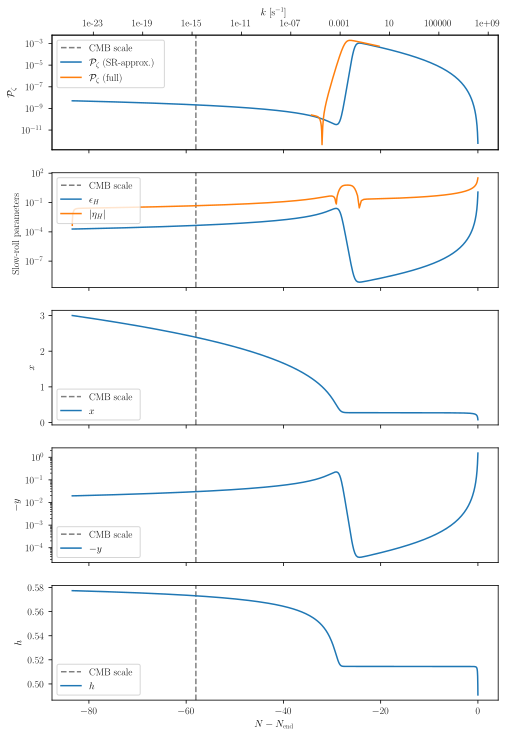

In [3]:
# Set some fiducial parameter values for the pontential
pvalues = [
    0.7122360088466501,
    1.47312e-06,
    0.19688844475447168,
    1.8690166574800342e-05,
]

# This command plots hte evolution of the field and P_zeta for
# the background and the perturbations.
fig = robbiesmodel.plot_evolution(k, pvalues)
pzeta = robbiesmodel.run(k, *pvalues)
plt.show()

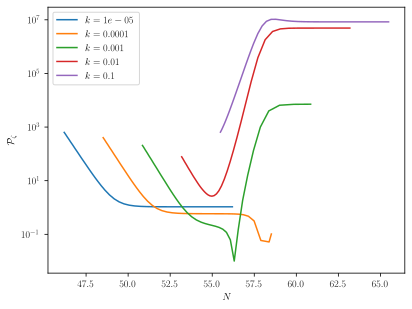

In [4]:
# Plot a few modes evolving 
modes = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
N, phi, y, h = robbiesmodel.run_background(pvalues)

fig, ax = plt.subplots()
for mode in modes:
    sol, lograt = robbiesmodel.run_single_k(mode, N, phi, y, h, pvalues)
    Pzeta_by_V0 = (
    1
    / (4 * jnp.pi**2)
    * jnp.exp(2 * lograt)
    * (sol.ys.T[3]**2 + sol.ys.T[5]**2)
    / sol.ys.T[1]**2
    )
    ax.plot(sol.ts, Pzeta_by_V0, label=f'$k={mode}$')
ax.set_xlabel(r'$N$')
ax.set_yscale('log')
ax.set_ylabel(r'$\mathcal{P}_\zeta$')
ax.legend()
plt.show()

In [5]:
# Set up a Omega_GW integrator which uses the single field solver
# as template

f = jnp.geomspace(1e-5, 1., 200) # The frequencies to calculate Omega_GW
s = jnp.linspace(0, 1, 10) # First rescaled internal momentum
t = jnp.logspace(-3, 3, 1000) # Second rescaled internal momentum

# Expand t to add a new axis
t_expanded = jnp.expand_dims(t, axis=-1)
# Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(f), axis=-1)

integrator = OmegaGWms(robbiesmodel, s, t, f=f, kernel="RD", upsample=True)

In [6]:
# Initial evaluation to compile the function
Omega_GW = integrator(f, *pvalues)

# Time the evaluation
n_recalc = 20
start_time = time.time()
for _ in range(n_recalc):
    Omega_GW = integrator(f, *pvalues)
end_time = time.time()
print(f"Time taken ({n_recalc} iterations): ", end_time - start_time)
print("Time taken per iteration: ", (end_time - start_time)/n_recalc)

    

Time taken (20 iterations):  12.533896446228027
Time taken per iteration:  0.6266948223114014


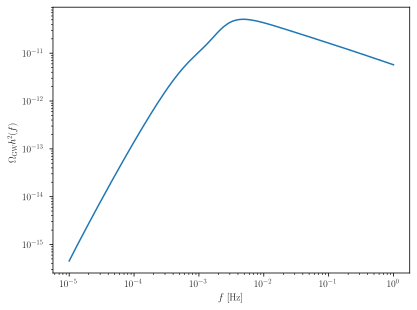

In [7]:
# Plot Omega_GW
plt.figure()
plt.loglog(f, Omega_GW)
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$\Omega_{\rm GW}h^2(f)$')
plt.show()

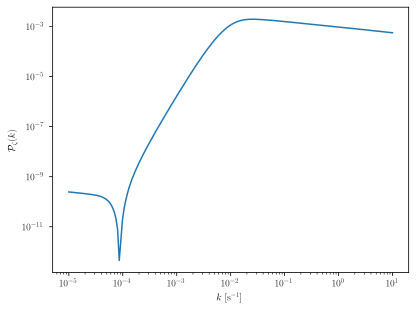

In [8]:
# Plot P_zeta
plt.figure()
plt.loglog(k, pzeta(k))
plt.xlabel(r'$k$ [s$^{-1}$]')
plt.ylabel(r'$\mathcal{P}_{\zeta}(k)$')
plt.show()